In [2]:
import pandas as pd

df = pd.read_csv('qtdbsel102.txt', header=None, delimiter='\t')
df.head()

,0,1,2
0,200.000,4.770,2.100
1,200.004,4.820,2.135
2,200.008,4.805,2.190
3,200.012,4.750,2.285
4,200.016,4.710,2.440


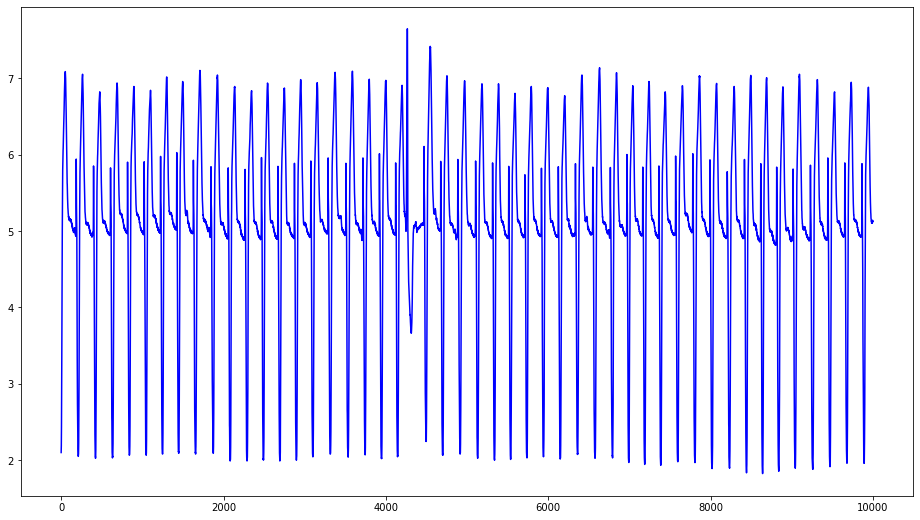

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

ecg_dataset = df.iloc[:,2].values
ecg_dataset = ecg_dataset[:10000]
ecg_dataset = ecg_dataset.reshape(len(ecg_dataset), -1)

plt.figure(figsize=(16, 9))
plt.plot(ecg_dataset, color='b')
plt.show()

In [4]:
import numpy as np

# 平均値を0にする
ecg_dataset_mean = ecg_dataset.mean()
ecg_dataset = (ecg_dataset - ecg_dataset_mean)

# データセットの最大値で割り、-1～1の範囲に収まるように正規化する
ecg_dataset_max = np.abs(ecg_dataset).max()
ecg_dataset = ecg_dataset / ecg_dataset_max

In [5]:
train_data = ecg_dataset[5000:10000]
test_data = ecg_dataset[:5000]

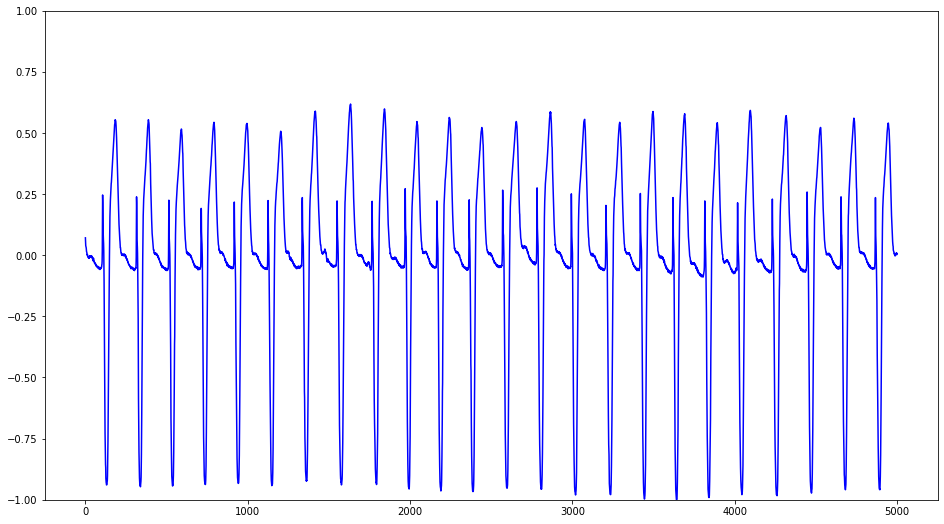

In [6]:
# 学習データプロット
plt.figure(figsize=(16, 9))
plt.ylim(-1, 1)
plt.plot(train_data, color='b')
plt.show()

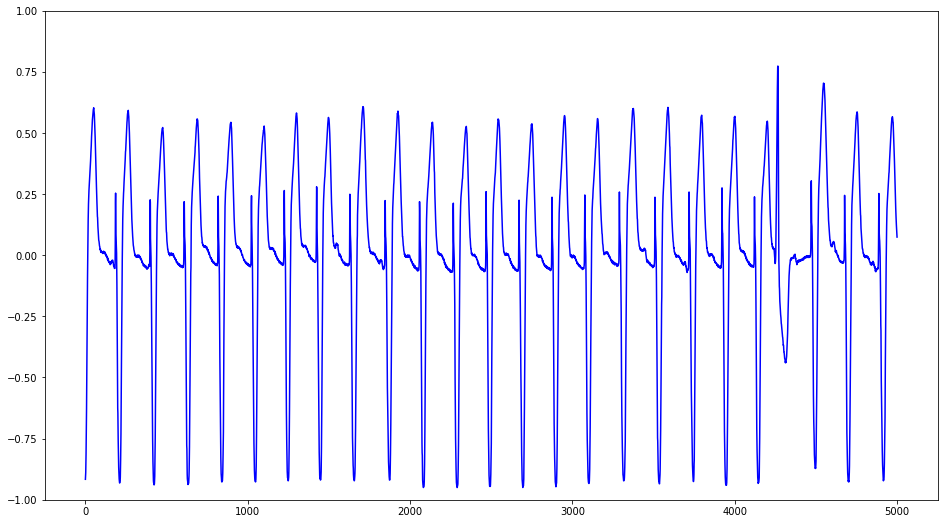

In [7]:
# テストデータプロット
plt.figure(figsize=(16, 9))
plt.ylim(-1, 1)
plt.plot(test_data, color='b')
plt.show()

In [8]:
TIME_STEPS = 128

def create_dataset_list(array, time_steps=TIME_STEPS):
    dataset_list = []

    for i in range(len(array) - time_steps + 1):
        dataset_list.append(array[i : (i + time_steps)])

    return np.stack(dataset_list)

In [9]:
x_train = create_dataset_list(train_data)

print(train_data.shape)
print(x_train.shape)

(5000, 1)
(4873, 128, 1)


In [10]:
x_test = create_dataset_list(test_data)

print(test_data.shape)
print(x_test.shape)

(5000, 1)
(4873, 128, 1)


In [11]:
import os
import random
import tensorflow as tf

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [12]:
model = tf.keras.Sequential(
    [
        # 入力層
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS, 1)),
     
        # エンコード層
        tf.keras.layers.Conv1D(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
       
        # デコード層
        tf.keras.layers.Conv1DTranspose(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Conv1DTranspose(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
    
        # 出力層
        tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)

2021-11-13 19:41:58.291013: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 64, 64)            512       
                                                                 
 dropout (Dropout)           (None, 64, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 32)            14368     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 64, 64)           14400     
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 128, 64)          28736     
 ranspose)                                              

In [14]:
history = model.fit(
    x=x_train,  # 学習データ
    y=x_train,  # 教師データ(オートエンコーダの学習のため学習データをそのまま入れる)
    validation_split=0.1,  # 検証データ比率(学習データの1割を検証データとして使用する)
    epochs=50,  # エポック数
    batch_size=128,  # バッチサイズ
    callbacks=[
        # コールバック指定
        # 5回検証Lossの改善が無かったら学習を打ち切るよう設定
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
35/35 [==============================] - 2s 47ms/step - loss: 0.0348 - val_loss: 0.0043
Epoch 2/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 3/50
35/35 [==============================] - 1s 41ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 4/50
35/35 [==============================] - 1s 41ms/step - loss: 0.0021 - val_loss: 8.7375e-04
Epoch 5/50
35/35 [==============================] - 1s 40ms/step - loss: 0.0015 - val_loss: 6.4822e-04
Epoch 6/50
35/35 [==============================] - 1s 39ms/step - loss: 0.0012 - val_loss: 4.5074e-04
Epoch 7/50
35/35 [==============================] - 1s 43ms/step - loss: 9.5630e-04 - val_loss: 3.3949e-04
Epoch 8/50
35/35 [==============================] - 1s 41ms/step - loss: 8.4134e-04 - val_loss: 5.7747e-04
Epoch 9/50
35/35 [==============================] - 1s 39ms/step - loss: 7.6802e-04 - val_loss: 5.6147e-04
Epoch 10/50
35/35 [==============================] - 1s 38ms/step - loss:

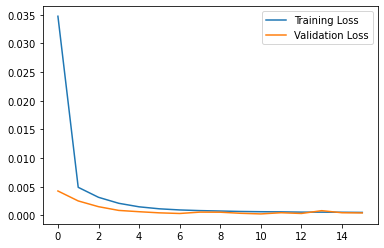

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [16]:
temp_data = x_train[0]
temp_data = temp_data.reshape(-1, 128, 1)

In [17]:
temp_result = model.predict(temp_data)

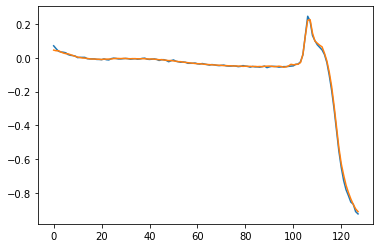

In [18]:
plt.plot(temp_data[0])
plt.plot(temp_result[0])
plt.show()

In [19]:
x_train_predict_result = model.predict(x_train)

In [20]:
train_abs = np.abs(x_train_predict_result - x_train)
train_mae = np.mean(train_abs, axis=1)
train_mae = train_mae.reshape(-1)

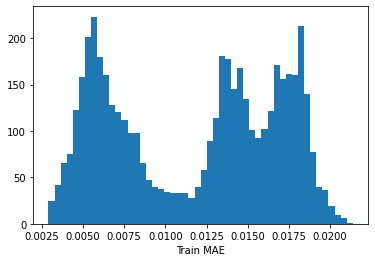

In [21]:
plt.hist(train_mae, bins=50)
plt.xlabel("Train MAE")
plt.show()

In [22]:
threshold = np.max(train_mae)
print(threshold)

0.021375342583417983


In [23]:
x_test_predict_result = model.predict(x_test)

In [24]:
test_abs = np.abs(x_test_predict_result - x_test)
test_mae = np.mean(test_abs, axis=1)
test_mae = test_mae.reshape(-1)

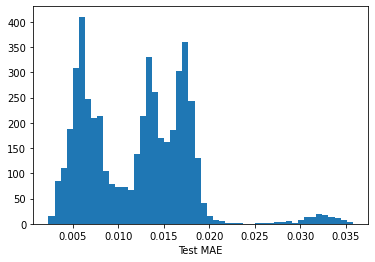

In [25]:
plt.hist(test_mae, bins=50)
plt.xlabel("Test MAE")
plt.show()

In [26]:
anomaly_result = test_mae > threshold

# 異常検知個数
print(np.sum(anomaly_result))

# 異常検知したインデックス
print(np.where(anomaly_result))

129
(array([4137, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149,
       4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160,
       4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171,
       4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182,
       4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193,
       4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204,
       4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215,
       4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226,
       4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237,
       4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248,
       4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259,
       4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267]),)


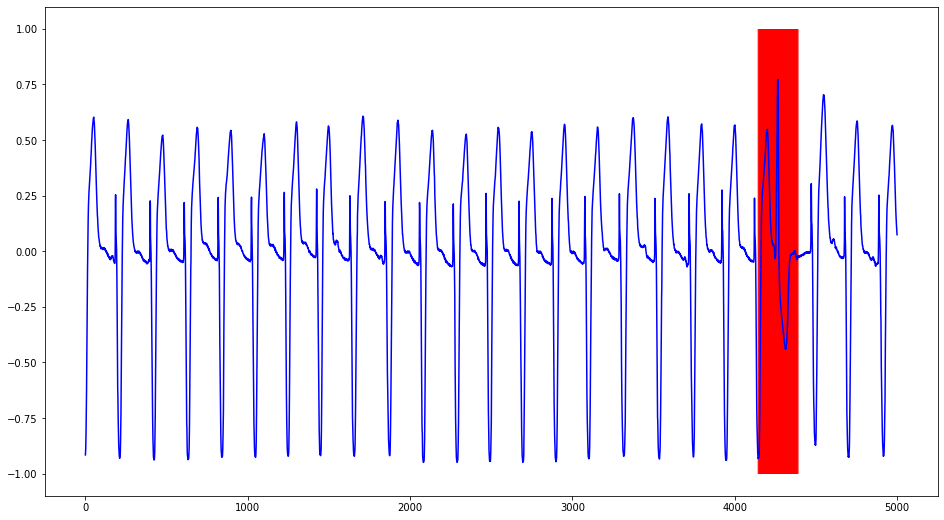

In [27]:
plt.figure(figsize=(16, 9))
plt.plot(test_data, color="b")

for index, anomaly in enumerate(anomaly_result):
    if anomaly:
        x = np.arange(index, index + TIME_STEPS)
        y1 = [-1]*len(x)
        y2 = [1]*len(x)
        plt.fill_between(x, y1, y2, facecolor='r', alpha=.3)

In [28]:
def create_model(time_steps, num_layer, num_filters, kernel_size, strides, dropout_rate, activation):
    model = tf.keras.Sequential()

    # 入力層
    model.add(tf.keras.layers.InputLayer(input_shape=(time_steps, 1)))

    # エンコード層
    for i in range(num_layer):
        filters = int(num_filters / (i+1))

        model.add(
            tf.keras.layers.Conv1D(
                filters=filters, kernel_size=kernel_size, padding="same", strides=strides, activation=activation
            )
        )
        if i < (num_layer - 1):
            model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # デコード層
    for i in reversed(range(num_layer)):
        filters = int(num_filters / (i+1))

        model.add(
            tf.keras.layers.Conv1DTranspose(
                filters=filters, kernel_size=kernel_size, padding="same", strides=strides, activation=activation
            )
        )
        if i != 0:
            model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # 出力層
    model.add(
        tf.keras.layers.Conv1DTranspose(
            filters=1, kernel_size=kernel_size, padding="same"
        )
    )

    return model

In [29]:
import optuna

def objective(trial):
    # レイヤー数
    num_layer = trial.suggest_int("num_layer", 1, 3)
    # 畳み込みフィルター数
    num_filters = int(trial.suggest_categorical("num_filters", [16, 32, 64]))
    # 畳み込みカーネルサイズ
    kernel_size = trial.suggest_int("kernel_size", 1, 5, 2)
    # 畳み込みストライドサイズ
    strides = trial.suggest_int("strides", 2, 4, 2)
    # ドロップアウト割合
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    # 活性化関数
    activation = trial.suggest_categorical("activation", ["relu", "sigmoid", "tanh"])
    
    # 最適化アルゴリズム
    optimizer = trial.suggest_categorical("optimizer", ["sgd", "adam"])

    # モデル構築・コンパイル
    model = create_model(TIME_STEPS, num_layer, num_filters, kernel_size, strides, dropout_rate, activation)
    model.compile(
        optimizer=optimizer,
        loss="mse"
    )

    model.summary()
    
    # 訓練開始
    history = model.fit(
        x_train,
        x_train,
        epochs=50,
        batch_size=128,
        validation_split=0.1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )
    
    return history.history["val_loss"][-1]

In [30]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-11-13 19:42:24,601] A new study created in memory with name: no-name-40da656e-11ba-4929-b284-bc6108289000


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 64, 32)            64        
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 128, 32)          1056      
 ranspose)                                                       
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 128, 1)           33        
 ranspose)                                                       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0917 - val_loss: 0.0708
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0664 - val_l

[I 2021-11-13 19:42:26,492] Trial 0 finished with value: 0.06894233077764511 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 1, 'strides': 2, 'dropout_rate': 0.1021025599662222, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 0 with value: 0.06894233077764511.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 32, 16)            96        
                                                                 
 dropout_2 (Dropout)         (None, 32, 16)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 8, 8)              648       
                                                                 
 dropout_3 (Dropout)         (None, 8, 8)              0         
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 5)              205       
                                                                 
 conv1d_transpose_5 (Conv1DT  (None, 8, 5)             130       
 ranspose)                                                       
                                                      

[I 2021-11-13 19:42:40,882] Trial 1 finished with value: 0.0030540272127836943 and parameters: {'num_layer': 3, 'num_filters': 16, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.2205379813563661, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 1 with value: 0.0030540272127836943.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 32, 64)            384       
                                                                 
 dropout_6 (Dropout)         (None, 32, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 8, 32)             10272     
                                                                 
 dropout_7 (Dropout)         (None, 8, 32)             0         
                                                                 
 conv1d_8 (Conv1D)           (None, 2, 21)             3381      
                                                                 
 conv1d_transpose_9 (Conv1DT  (None, 8, 21)            2226      
 ranspose)                                                       
                                                      

[I 2021-11-13 19:42:50,986] Trial 2 finished with value: 0.0030531848315149546 and parameters: {'num_layer': 3, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.1366816811946217, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 2 with value: 0.0030531848315149546.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 32, 64)            384       
                                                                 
 dropout_10 (Dropout)        (None, 32, 64)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 8, 32)             10272     
                                                                 
 conv1d_transpose_13 (Conv1D  (None, 32, 32)           5152      
 Transpose)                                                      
                                                                 
 dropout_11 (Dropout)        (None, 32, 32)            0         
                                                                 
 conv1d_transpose_14 (Conv1D  (None, 128, 64)          10304     
 Transpose)                                           

[I 2021-11-13 19:43:22,097] Trial 3 finished with value: 0.005726265721023083 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 5, 'strides': 4, 'dropout_rate': 0.4974152885712641, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.0030531848315149546.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 64, 64)            256       
                                                                 
 conv1d_transpose_16 (Conv1D  (None, 128, 64)          12352     
 Transpose)                                                      
                                                                 
 conv1d_transpose_17 (Conv1D  (None, 128, 1)           193       
 Transpose)                                                      
                                                                 
Total params: 12,801
Trainable params: 12,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 15ms/step - loss: 0.1371 - val_loss: 0.1416
Epoch 2/50
35/35 [==============================] - 0s 12ms/step - loss: 0.1349 - v

[I 2021-11-13 19:43:43,890] Trial 4 finished with value: 0.10303841531276703 and parameters: {'num_layer': 1, 'num_filters': 64, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.40437566655863866, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.0030531848315149546.


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 32, 16)            32        
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 128, 16)          272       
 Transpose)                                                      
                                                                 
 conv1d_transpose_19 (Conv1D  (None, 128, 1)           17        
 Transpose)                                                      
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 6ms/step - loss: 0.1228 - val_loss: 0.1276
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.1205 - val_loss:

[I 2021-11-13 19:43:49,853] Trial 5 finished with value: 0.10415686666965485 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 1, 'strides': 4, 'dropout_rate': 0.15729772735631303, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.0030531848315149546.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 32, 32)            64        
                                                                 
 dropout_12 (Dropout)        (None, 32, 32)            0         
                                                                 
 conv1d_14 (Conv1D)          (None, 8, 16)             528       
                                                                 
 dropout_13 (Dropout)        (None, 8, 16)             0         
                                                                 
 conv1d_15 (Conv1D)          (None, 2, 10)             170       
                                                                 
 conv1d_transpose_20 (Conv1D  (None, 8, 10)            110       
 Transpose)                                                      
                                                      

[I 2021-11-13 19:43:52,846] Trial 6 finished with value: 0.13583700358867645 and parameters: {'num_layer': 3, 'num_filters': 32, 'kernel_size': 1, 'strides': 4, 'dropout_rate': 0.44724213630158094, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 2 with value: 0.0030531848315149546.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 32, 16)            32        
                                                                 
 dropout_16 (Dropout)        (None, 32, 16)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 8, 8)              136       
                                                                 
 dropout_17 (Dropout)        (None, 8, 8)              0         
                                                                 
 conv1d_18 (Conv1D)          (None, 2, 5)              45        
                                                                 
 conv1d_transpose_24 (Conv1D  (None, 8, 5)             30        
 Transpose)                                                      
                                                      

[I 2021-11-13 19:44:02,766] Trial 7 finished with value: 0.13780313730239868 and parameters: {'num_layer': 3, 'num_filters': 16, 'kernel_size': 1, 'strides': 4, 'dropout_rate': 0.24206496071073857, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.0030531848315149546.


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 32, 64)            256       
                                                                 
 dropout_20 (Dropout)        (None, 32, 64)            0         
                                                                 
 conv1d_20 (Conv1D)          (None, 8, 32)             6176      
                                                                 
 conv1d_transpose_28 (Conv1D  (None, 32, 32)           3104      
 Transpose)                                                      
                                                                 
 dropout_21 (Dropout)        (None, 32, 32)            0         
                                                                 
 conv1d_transpose_29 (Conv1D  (None, 128, 64)          6208      
 Transpose)                                           

[I 2021-11-13 19:44:29,870] Trial 8 finished with value: 0.028734618797898293 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.2677459450334628, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 2 with value: 0.0030531848315149546.


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 64, 32)            128       
                                                                 
 dropout_22 (Dropout)        (None, 64, 32)            0         
                                                                 
 conv1d_22 (Conv1D)          (None, 32, 16)            1552      
                                                                 
 conv1d_transpose_31 (Conv1D  (None, 64, 16)           784       
 Transpose)                                                      
                                                                 
 dropout_23 (Dropout)        (None, 64, 16)            0         
                                                                 
 conv1d_transpose_32 (Conv1D  (None, 128, 32)          1568      
 Transpose)                                          

[I 2021-11-13 19:44:35,688] Trial 9 finished with value: 0.13791674375534058 and parameters: {'num_layer': 2, 'num_filters': 32, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.2075582123964243, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.0030531848315149546.


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_23 (Conv1D)          (None, 64, 64)            384       
                                                                 
 dropout_24 (Dropout)        (None, 64, 64)            0         
                                                                 
 conv1d_24 (Conv1D)          (None, 32, 32)            10272     
                                                                 
 dropout_25 (Dropout)        (None, 32, 32)            0         
                                                                 
 conv1d_25 (Conv1D)          (None, 16, 21)            3381      
                                                                 
 conv1d_transpose_34 (Conv1D  (None, 32, 21)           2226      
 Transpose)                                                      
                                                     

[I 2021-11-13 19:45:36,269] Trial 10 finished with value: 6.829015183029696e-05 and parameters: {'num_layer': 3, 'num_filters': 64, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.001515325634656589, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 10 with value: 6.829015183029696e-05.


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 64, 64)            384       
                                                                 
 dropout_28 (Dropout)        (None, 64, 64)            0         
                                                                 
 conv1d_27 (Conv1D)          (None, 32, 32)            10272     
                                                                 
 dropout_29 (Dropout)        (None, 32, 32)            0         
                                                                 
 conv1d_28 (Conv1D)          (None, 16, 21)            3381      
                                                                 
 conv1d_transpose_38 (Conv1D  (None, 32, 21)           2226      
 Transpose)                                                      
                                                     

[I 2021-11-13 19:45:47,941] Trial 11 finished with value: 0.0027985405176877975 and parameters: {'num_layer': 3, 'num_filters': 64, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.0874344732102034, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 10 with value: 6.829015183029696e-05.


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 64, 64)            384       
                                                                 
 dropout_32 (Dropout)        (None, 64, 64)            0         
                                                                 
 conv1d_30 (Conv1D)          (None, 32, 32)            10272     
                                                                 
 dropout_33 (Dropout)        (None, 32, 32)            0         
                                                                 
 conv1d_31 (Conv1D)          (None, 16, 21)            3381      
                                                                 
 conv1d_transpose_42 (Conv1D  (None, 32, 21)           2226      
 Transpose)                                                      
                                                     

[I 2021-11-13 19:46:10,217] Trial 12 finished with value: 0.00040123722283169627 and parameters: {'num_layer': 3, 'num_filters': 64, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.028603437868115884, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 10 with value: 6.829015183029696e-05.


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 64, 64)            384       
                                                                 
 dropout_36 (Dropout)        (None, 64, 64)            0         
                                                                 
 conv1d_33 (Conv1D)          (None, 32, 32)            10272     
                                                                 
 dropout_37 (Dropout)        (None, 32, 32)            0         
                                                                 
 conv1d_34 (Conv1D)          (None, 16, 21)            3381      
                                                                 
 conv1d_transpose_46 (Conv1D  (None, 32, 21)           2226      
 Transpose)                                                      
                                                     

[I 2021-11-13 19:46:52,807] Trial 13 finished with value: 0.00012519834854174405 and parameters: {'num_layer': 3, 'num_filters': 64, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.013658720530650429, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 10 with value: 6.829015183029696e-05.


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_35 (Conv1D)          (None, 64, 64)            384       
                                                                 
 dropout_40 (Dropout)        (None, 64, 64)            0         
                                                                 
 conv1d_36 (Conv1D)          (None, 32, 32)            10272     
                                                                 
 conv1d_transpose_50 (Conv1D  (None, 64, 32)           5152      
 Transpose)                                                      
                                                                 
 dropout_41 (Dropout)        (None, 64, 32)            0         
                                                                 
 conv1d_transpose_51 (Conv1D  (None, 128, 64)          10304     
 Transpose)                                          

[I 2021-11-13 19:47:45,279] Trial 14 finished with value: 1.4134177945379633e-05 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.00013433652737921157, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: 1.4134177945379633e-05.


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 64, 64)            256       
                                                                 
 dropout_42 (Dropout)        (None, 64, 64)            0         
                                                                 
 conv1d_38 (Conv1D)          (None, 32, 32)            6176      
                                                                 
 conv1d_transpose_53 (Conv1D  (None, 64, 32)           3104      
 Transpose)                                                      
                                                                 
 dropout_43 (Dropout)        (None, 64, 32)            0         
                                                                 
 conv1d_transpose_54 (Conv1D  (None, 128, 64)          6208      
 Transpose)                                          

[I 2021-11-13 19:47:53,659] Trial 15 finished with value: 0.004900048021227121 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.33344719875587125, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: 1.4134177945379633e-05.


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_39 (Conv1D)          (None, 64, 64)            384       
                                                                 
 dropout_44 (Dropout)        (None, 64, 64)            0         
                                                                 
 conv1d_40 (Conv1D)          (None, 32, 32)            10272     
                                                                 
 conv1d_transpose_56 (Conv1D  (None, 64, 32)           5152      
 Transpose)                                                      
                                                                 
 dropout_45 (Dropout)        (None, 64, 32)            0         
                                                                 
 conv1d_transpose_57 (Conv1D  (None, 128, 64)          10304     
 Transpose)                                          

[I 2021-11-13 19:48:46,388] Trial 16 finished with value: 1.777115357981529e-05 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.003658501429937754, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: 1.4134177945379633e-05.


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_41 (Conv1D)          (None, 64, 64)            256       
                                                                 
 dropout_46 (Dropout)        (None, 64, 64)            0         
                                                                 
 conv1d_42 (Conv1D)          (None, 32, 32)            6176      
                                                                 
 conv1d_transpose_59 (Conv1D  (None, 64, 32)           3104      
 Transpose)                                                      
                                                                 
 dropout_47 (Dropout)        (None, 64, 32)            0         
                                                                 
 conv1d_transpose_60 (Conv1D  (None, 128, 64)          6208      
 Transpose)                                          

[I 2021-11-13 19:48:58,933] Trial 17 finished with value: 0.000494490610435605 and parameters: {'num_layer': 2, 'num_filters': 64, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.06659805461089949, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: 1.4134177945379633e-05.


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 64, 32)            192       
                                                                 
 dropout_48 (Dropout)        (None, 64, 32)            0         
                                                                 
 conv1d_44 (Conv1D)          (None, 32, 16)            2576      
                                                                 
 conv1d_transpose_62 (Conv1D  (None, 64, 16)           1296      
 Transpose)                                                      
                                                                 
 dropout_49 (Dropout)        (None, 64, 16)            0         
                                                                 
 conv1d_transpose_63 (Conv1D  (None, 128, 32)          2592      
 Transpose)                                          

[I 2021-11-13 19:49:08,731] Trial 18 finished with value: 0.0017004833789542317 and parameters: {'num_layer': 2, 'num_filters': 32, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.15901390177618746, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: 1.4134177945379633e-05.


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_45 (Conv1D)          (None, 64, 16)            96        
                                                                 
 conv1d_transpose_65 (Conv1D  (None, 128, 16)          1296      
 Transpose)                                                      
                                                                 
 conv1d_transpose_66 (Conv1D  (None, 128, 1)           81        
 Transpose)                                                      
                                                                 
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0531 - val_loss: 0.0120
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0048 - val_

[I 2021-11-13 19:49:18,457] Trial 19 finished with value: 1.305604564549867e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 5, 'strides': 2, 'dropout_rate': 0.05035159652607497, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 19 with value: 1.305604564549867e-05.


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_46 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_67 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_68 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0743 - val_loss: 0.0300
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0146 - val_loss

[I 2021-11-13 19:49:26,770] Trial 20 finished with value: 4.482947133510606e-06 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.06586991553059357, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_47 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_69 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_70 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.1272 - val_loss: 0.0807
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0406 - val_loss

[I 2021-11-13 19:49:34,935] Trial 21 finished with value: 2.8780455977539532e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.0627677391453064, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_71 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_72 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0867 - val_loss: 0.0397
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0148 - val_loss

[I 2021-11-13 19:49:43,716] Trial 22 finished with value: 4.7126713980105706e-06 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.1152734919737688, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_49 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_73 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_74 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0679 - val_loss: 0.0248
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0082 - val_loss

[I 2021-11-13 19:49:52,402] Trial 23 finished with value: 1.2555342436826322e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.12929307555402625, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_50 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_75 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_76 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0691 - val_loss: 0.0153
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss

[I 2021-11-13 19:50:01,094] Trial 24 finished with value: 8.099233127722982e-06 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.12091919402145292, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_51 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_77 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_78 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0693 - val_loss: 0.0270
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss

[I 2021-11-13 19:50:08,940] Trial 25 finished with value: 2.2712374629918486e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.17583649755253233, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_79 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_80 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.1291 - val_loss: 0.1246
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.1115 - val_loss

[I 2021-11-13 19:50:16,752] Trial 26 finished with value: 0.0013963968958705664 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.2878499353564916, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_53 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_81 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_82 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0598 - val_loss: 0.0309
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0229 - val_loss

[I 2021-11-13 19:50:24,714] Trial 27 finished with value: 8.75816294865217e-06 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.1050499670961387, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_83 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_84 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.1553 - val_loss: 0.1401
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.1286 - val_loss

[I 2021-11-13 19:50:32,792] Trial 28 finished with value: 0.0005628647049888968 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.19240681699080414, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_55 (Conv1D)          (None, 64, 16)            32        
                                                                 
 conv1d_transpose_85 (Conv1D  (None, 128, 16)          272       
 Transpose)                                                      
                                                                 
 conv1d_transpose_86 (Conv1D  (None, 128, 1)           17        
 Transpose)                                                      
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 6ms/step - loss: 0.0912 - val_loss: 0.0696
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0661 - val_loss

[I 2021-11-13 19:50:35,503] Trial 29 finished with value: 0.068999744951725 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 1, 'strides': 2, 'dropout_rate': 0.10676901790801704, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_56 (Conv1D)          (None, 64, 16)            32        
                                                                 
 conv1d_transpose_87 (Conv1D  (None, 128, 16)          272       
 Transpose)                                                      
                                                                 
 conv1d_transpose_88 (Conv1D  (None, 128, 1)           17        
 Transpose)                                                      
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 6ms/step - loss: 0.0703 - val_loss: 0.0694
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0660 - val_loss

[I 2021-11-13 19:50:38,146] Trial 30 finished with value: 0.06897494941949844 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 1, 'strides': 2, 'dropout_rate': 0.08901701094241388, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_57 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_89 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_90 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0701 - val_loss: 0.0253
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss

[I 2021-11-13 19:50:47,084] Trial 31 finished with value: 1.2581614100781735e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.10968092362425053, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_58 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_91 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_92 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 17ms/step - loss: 0.0872 - val_loss: 0.0430
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0131 - val_los

[I 2021-11-13 19:50:55,190] Trial 32 finished with value: 6.761945314792683e-06 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.13073143521622635, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_59 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_93 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_94 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 7ms/step - loss: 0.0521 - val_loss: 0.0059
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss

[I 2021-11-13 19:51:03,086] Trial 33 finished with value: 2.9829936465830542e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.04559226112866624, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_95 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_96 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 7ms/step - loss: 0.0820 - val_loss: 0.0354
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss

[I 2021-11-13 19:51:11,080] Trial 34 finished with value: 1.6018981114029884e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.13926217315515507, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_61 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_97 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_98 (Conv1D  (None, 128, 1)           49        
 Transpose)                                                      
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0453 - val_loss: 0.0054
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss

[I 2021-11-13 19:51:19,200] Trial 35 finished with value: 5.2401170250959694e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.22229165180676208, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_62 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_99 (Conv1D  (None, 128, 16)          784       
 Transpose)                                                      
                                                                 
 conv1d_transpose_100 (Conv1  (None, 128, 1)           49        
 DTranspose)                                                     
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.1254 - val_loss: 0.1208
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.1098 - val_loss

[I 2021-11-13 19:51:27,918] Trial 36 finished with value: 0.0013104084646329284 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.13359432758671966, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_63 (Conv1D)          (None, 32, 32)            128       
                                                                 
 conv1d_transpose_101 (Conv1  (None, 128, 32)          3104      
 DTranspose)                                                     
                                                                 
 conv1d_transpose_102 (Conv1  (None, 128, 1)           97        
 DTranspose)                                                     
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 9ms/step - loss: 0.0843 - val_loss: 0.0347
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0135 - val_

[I 2021-11-13 19:51:36,980] Trial 37 finished with value: 4.444105798029341e-05 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.3235079136384593, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_64 (Conv1D)          (None, 64, 16)            32        
                                                                 
 conv1d_transpose_103 (Conv1  (None, 128, 16)          272       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_104 (Conv1  (None, 128, 1)           17        
 DTranspose)                                                     
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 0s 6ms/step - loss: 0.1033 - val_loss: 0.1052
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0976 - val_loss

[I 2021-11-13 19:51:43,545] Trial 38 finished with value: 0.06950046867132187 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 1, 'strides': 2, 'dropout_rate': 0.17980511537739094, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_65 (Conv1D)          (None, 32, 16)            64        
                                                                 
 conv1d_transpose_105 (Conv1  (None, 128, 16)          784       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_106 (Conv1  (None, 128, 1)           49        
 DTranspose)                                                     
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 6ms/step - loss: 0.3548 - val_loss: 0.1392
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.1331 - val_loss

[I 2021-11-13 19:51:49,352] Trial 39 finished with value: 0.0013235415099188685 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 4, 'dropout_rate': 0.07726378816074128, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_66 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_107 (Conv1  (None, 128, 16)          784       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_108 (Conv1  (None, 128, 1)           49        
 DTranspose)                                                     
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 7ms/step - loss: 0.0679 - val_loss: 0.0020
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss

[I 2021-11-13 19:51:57,589] Trial 40 finished with value: 5.446513387141749e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.15929617495239135, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_67 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_109 (Conv1  (None, 128, 16)          784       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_110 (Conv1  (None, 128, 1)           49        
 DTranspose)                                                     
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0584 - val_loss: 0.0146
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0047 - val_loss

[I 2021-11-13 19:52:06,243] Trial 41 finished with value: 2.127427615050692e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.10326775673621723, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 20 with value: 4.482947133510606e-06.


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_111 (Conv1  (None, 128, 16)          784       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_112 (Conv1  (None, 128, 1)           49        
 DTranspose)                                                     
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.0692 - val_loss: 0.0372
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0287 - val_loss

[I 2021-11-13 19:52:15,126] Trial 42 finished with value: 3.0135363431327278e-06 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.12184478377913334, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 42 with value: 3.0135363431327278e-06.


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_69 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_113 (Conv1  (None, 128, 16)          784       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_114 (Conv1  (None, 128, 1)           49        
 DTranspose)                                                     
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 7ms/step - loss: 0.0849 - val_loss: 0.0391
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0142 - val_loss

[I 2021-11-13 19:52:23,367] Trial 43 finished with value: 2.6085701392730698e-05 and parameters: {'num_layer': 1, 'num_filters': 16, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.1268296476269762, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 42 with value: 3.0135363431327278e-06.


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, 64, 32)            128       
                                                                 
 conv1d_transpose_115 (Conv1  (None, 128, 32)          3104      
 DTranspose)                                                     
                                                                 
 conv1d_transpose_116 (Conv1  (None, 128, 1)           97        
 DTranspose)                                                     
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 9ms/step - loss: 0.0671 - val_loss: 0.0107
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0030 - val_

[I 2021-11-13 19:52:34,625] Trial 44 finished with value: 3.1334620871348307e-06 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.03893279305353492, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 42 with value: 3.0135363431327278e-06.


Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_71 (Conv1D)          (None, 64, 32)            128       
                                                                 
 conv1d_transpose_117 (Conv1  (None, 128, 32)          3104      
 DTranspose)                                                     
                                                                 
 conv1d_transpose_118 (Conv1  (None, 128, 1)           97        
 DTranspose)                                                     
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 10ms/step - loss: 0.1393 - val_loss: 0.1404
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 0.1335 - val

[I 2021-11-13 19:52:45,760] Trial 45 finished with value: 0.09780227392911911 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.03442166192240101, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 42 with value: 3.0135363431327278e-06.


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 32, 32)            64        
                                                                 
 conv1d_transpose_119 (Conv1  (None, 128, 32)          1056      
 DTranspose)                                                     
                                                                 
 conv1d_transpose_120 (Conv1  (None, 128, 1)           33        
 DTranspose)                                                     
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.1207 - val_loss: 0.1129
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.1018 - val_

[I 2021-11-13 19:52:48,281] Trial 46 finished with value: 0.10339485108852386 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 1, 'strides': 4, 'dropout_rate': 0.07719874188887269, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 42 with value: 3.0135363431327278e-06.


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_73 (Conv1D)          (None, 64, 32)            128       
                                                                 
 conv1d_transpose_121 (Conv1  (None, 128, 32)          3104      
 DTranspose)                                                     
                                                                 
 conv1d_transpose_122 (Conv1  (None, 128, 1)           97        
 DTranspose)                                                     
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 1s 9ms/step - loss: 0.0421 - val_loss: 0.0024
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0016 - val_

[I 2021-11-13 19:52:59,519] Trial 47 finished with value: 6.257721452129772e-06 and parameters: {'num_layer': 1, 'num_filters': 32, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.031192384106140787, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 42 with value: 3.0135363431327278e-06.


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_74 (Conv1D)          (None, 64, 32)            128       
                                                                 
 dropout_50 (Dropout)        (None, 64, 32)            0         
                                                                 
 conv1d_75 (Conv1D)          (None, 32, 16)            1552      
                                                                 
 conv1d_transpose_123 (Conv1  (None, 64, 16)           784       
 DTranspose)                                                     
                                                                 
 dropout_51 (Dropout)        (None, 64, 16)            0         
                                                                 
 conv1d_transpose_124 (Conv1  (None, 128, 32)          1568      
 DTranspose)                                         

[I 2021-11-13 19:53:09,551] Trial 48 finished with value: 0.0002324204397154972 and parameters: {'num_layer': 2, 'num_filters': 32, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.026450240922466006, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 42 with value: 3.0135363431327278e-06.


Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_76 (Conv1D)          (None, 64, 32)            128       
                                                                 
 dropout_52 (Dropout)        (None, 64, 32)            0         
                                                                 
 conv1d_77 (Conv1D)          (None, 32, 16)            1552      
                                                                 
 conv1d_transpose_126 (Conv1  (None, 64, 16)           784       
 DTranspose)                                                     
                                                                 
 dropout_53 (Dropout)        (None, 64, 16)            0         
                                                                 
 conv1d_transpose_127 (Conv1  (None, 128, 32)          1568      
 DTranspose)                                         

[I 2021-11-13 19:53:33,382] Trial 49 finished with value: 0.003948308993130922 and parameters: {'num_layer': 2, 'num_filters': 32, 'kernel_size': 3, 'strides': 2, 'dropout_rate': 0.06143103498954572, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 42 with value: 3.0135363431327278e-06.


In [31]:
study.best_params

{'num_layer': 1,
 'num_filters': 16,
 'kernel_size': 3,
 'strides': 2,
 'dropout_rate': 0.12184478377913334,
 'activation': 'relu',
 'optimizer': 'adam'}

In [32]:
model2 = create_model(
    TIME_STEPS, 
    study.best_params['num_layer'], 
    study.best_params['num_filters'], 
    study.best_params['kernel_size'],
    study.best_params['strides'], 
    study.best_params['dropout_rate'],
    study.best_params['activation'],
)

model2.compile(optimizer=study.best_params['optimizer'], loss="mse")

model2.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_78 (Conv1D)          (None, 64, 16)            64        
                                                                 
 conv1d_transpose_129 (Conv1  (None, 128, 16)          784       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_130 (Conv1  (None, 128, 1)           49        
 DTranspose)                                                     
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model2.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
35/35 [==============================] - 1s 8ms/step - loss: 0.1211 - val_loss: 0.0711
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0302 - val_loss: 0.0036
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 9.0403e-04 - val_loss: 6.6841e-04
Epoch 5/50
35/35 [==============================] - 0s 4ms/step - loss: 6.8090e-04 - val_loss: 5.4635e-04
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 5.7111e-04 - val_loss: 4.6330e-04
Epoch 7/50
35/35 [==============================] - 0s 4ms/step - loss: 4.8514e-04 - val_loss: 3.9422e-04
Epoch 8/50
35/35 [==============================] - 0s 4ms/step - loss: 4.1460e-04 - val_loss: 3.4123e-04
Epoch 9/50
35/35 [==============================] - 0s 4ms/step - loss: 3.5627e-04 - val_loss: 2.9468e-04
Epoch 10/50
35/35 [==============================] - 0s 4ms/step - los

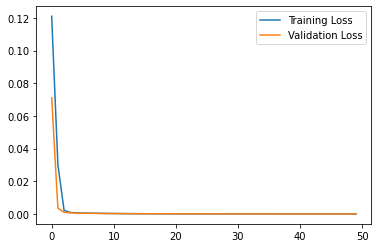

In [34]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [35]:
x_train_predict_result2 = model2.predict(x_train)

In [36]:
train_abs2 = np.abs(x_train_predict_result2 - x_train)
train_mae2 = np.mean(train_abs2, axis=1)
train_mae2 = train_mae2.reshape(-1)

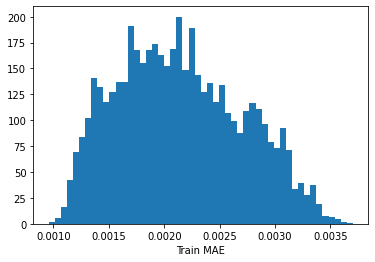

In [37]:
plt.hist(train_mae2, bins=50)
plt.xlabel("Train MAE")
plt.show()

In [39]:
threshold2 = np.max(train_mae2)
print(threshold2)

0.003702321111625449


In [40]:
x_test_predict_result2 = model2.predict(x_test)

In [41]:
test_abs2 = np.abs(x_test_predict_result2 - x_test)
test_mae2 = np.mean(test_abs2, axis=1)
test_mae2 = test_mae2.reshape(-1)

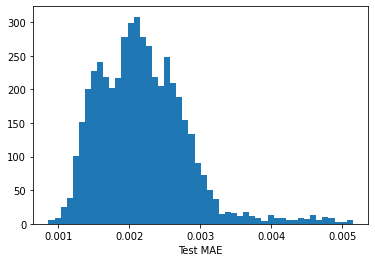

In [42]:
plt.hist(test_mae2, bins=50)
plt.xlabel("Test MAE")
plt.show()

In [43]:
anomaly_result2 = test_mae2 > threshold2
print(np.sum(anomaly_result2))
print(np.where(anomaly_result2))

126
(array([4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152,
       4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163,
       4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174,
       4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185,
       4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196,
       4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207,
       4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218,
       4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229,
       4230, 4231, 4232, 4233, 4235, 4237, 4239, 4241, 4243, 4245, 4247,
       4249, 4251, 4252, 4253, 4254, 4255, 4257, 4259, 4260, 4261, 4262,
       4263, 4264, 4265, 4266, 4267, 4444, 4445, 4446, 4448, 4450, 4468,
       4470, 4472, 4474, 4549, 4550]),)


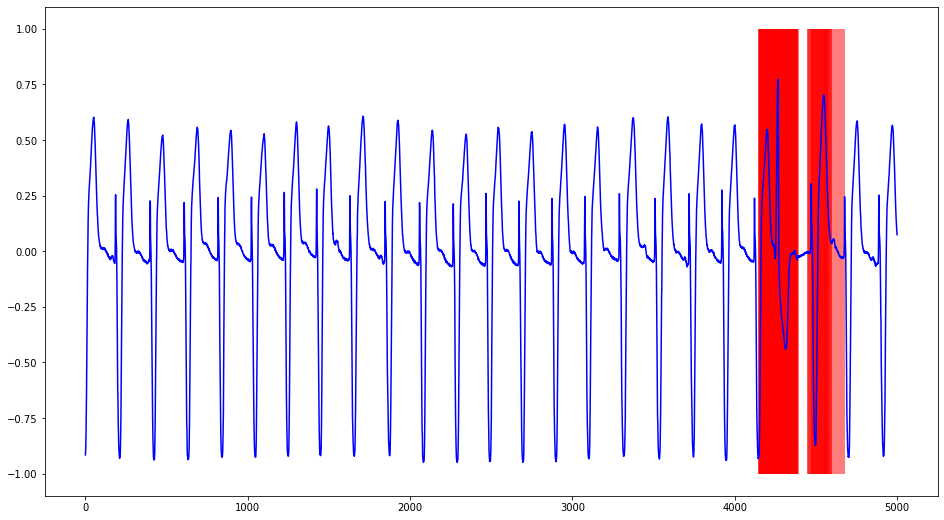

In [44]:
plt.figure(figsize=(16, 9))

plt.plot(test_data, color="b")

for index, anomaly in enumerate(anomaly_result2):
    if anomaly:
        x = np.arange(index, index + TIME_STEPS)
        y1 = [-1]*len(x)
        y2 = [1]*len(x)
        plt.fill_between(x, y1, y2, facecolor='r', alpha=.3)